# Kaggle


## Reference
https://www.kaggle.com/drscarlat/house-prices-all-done-via-pipeline

# Load Modules

In [1]:
from operator import itemgetter    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

from pandas.tools.plotting import scatter_matrix
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer
from sklearn.base import clone, BaseEstimator, TransformerMixin
#from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, cross_val_predict, StratifiedKFold, train_test_split, learning_curve, ShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
import lightgbm as lgb

print("Modules imported \n")

print("Files in current directory:")
import os
from subprocess import check_output
#print(check_output(["ls", "."]).decode("utf8")) #check the files available in the directory
# Any results you write to the current directory are saved as output.

Modules imported 

Files in current directory:


# Load raw data

In [2]:
# Load raw data
train = pd.read_csv('./train.csv') 
test = pd.read_csv('./test.csv') 
pd.set_option('max_columns', None)

# Locally 
#train = pd.read_csv('/Users/Alex/Desktop/HousingLinReg/train.csv') 
#test = pd.read_csv('/Users/Alex/Desktop/HousingLinReg/test.csv') 
print("train ", train.shape)
print("test ", test.shape)

train  (1460, 81)
test  (1459, 80)


# Visualizations


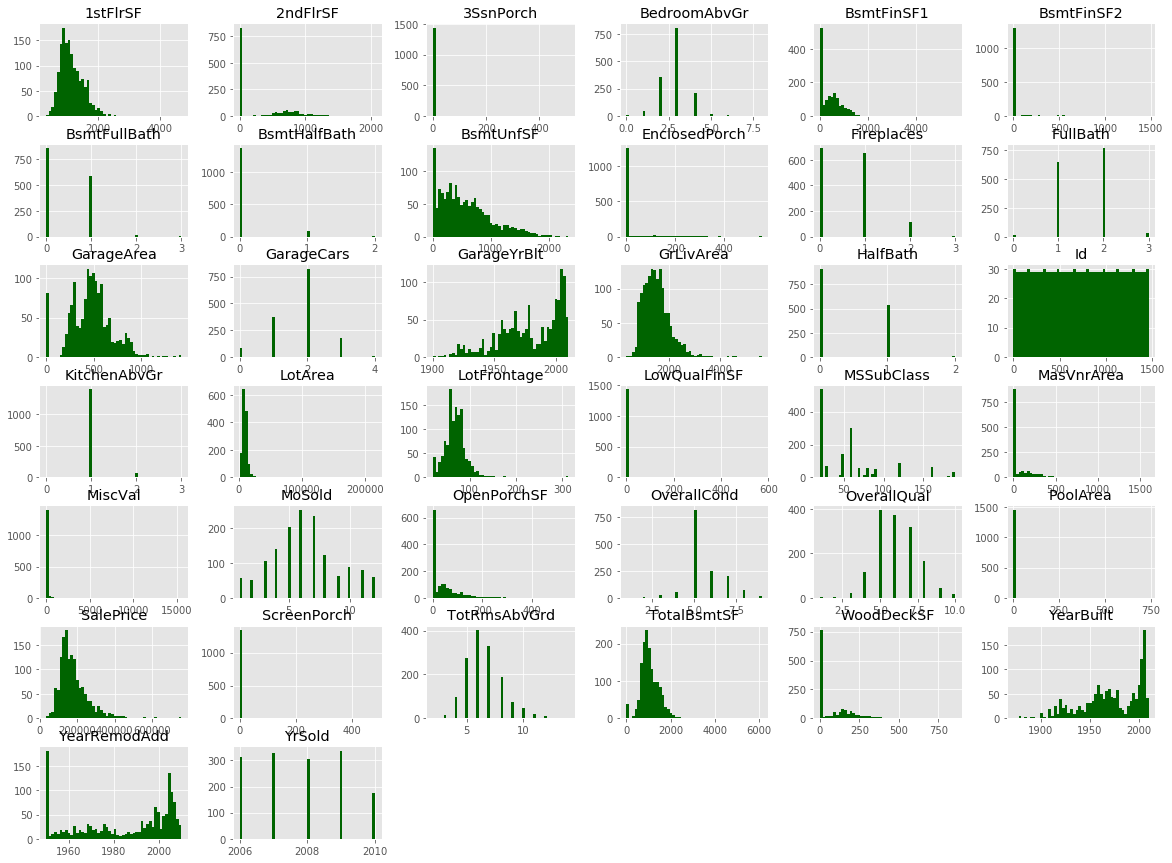

In [3]:
# Histograms
train.hist(bins=50, figsize=(20,15),color='darkgreen')
plt.show()

# Classes for Pipelines

## Feature Enginerinering

In [4]:
class feat_eng(BaseEstimator, TransformerMixin):
    def __init__(self, fill_missvals = True):
        self.fill_missvals = fill_missvals
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.fill_missvals:
            
            #Note 3 PoolQC' with None have Pool Area
            
            cols=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish']
            bcols=['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
            gcols=['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
            mcols=['MasVnrType','MSSubClass']
            for col in cols+bcols+gcols+mcols:
                X[col]=X[col].fillna('None')

            #Replace by 0 - Based on Descriptions
            b0cols=['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
            g0cols=['GarageYrBlt', 'GarageArea', 'GarageCars']
            m0cols=['MasVnrArea']
            for col in b0cols+g0cols+m0cols:
                X[col]=X[col].fillna(0)

                
            #Replace by Mode since high frequency
            mmcols=['Functional','SaleType', 'KitchenQual','Exterior2nd','Exterior1st','Electrical','MSZoning']
            for col in mmcols:
                X[col]=X[col].fillna(X[col].mode()[0])

            # A better technique can be used
            X["LotFrontage"] = X.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
            X = X.drop(['Utilities'], axis=1)
            
        return X

## Add Feature

In [5]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            #X["Age"] = X["YrSold"] - X["YearBuilt"]
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            #X["Age"] = X["YrSold"] - X["YearBuilt"]

        return X

## Skew Dummies

In [6]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.75):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        
        return X

## Label Encoder

In [7]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):      
        lab = LabelEncoder()
        
        #df['KitchenQual'] = pd.Categorical(df['KitchenQual'], categories=['Po', 'Fa', 'Ta', 'Gd', 'Ex'], ordered=True).codes
        
        qual_dic={'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}
        qual_dic1={'Ex':'A','Gd':'B','TA':'C','Fa':'D','Po':'E'}
        func_dic={'Typ':1, 'Min1':2, 'Maj1':3, 'Min2':4, 'Mod':5, 'Maj2':6, 'Sev':7}
                        
        qual_cols=['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual']
             
        for c in qual_cols:
            X[c] = pd.Categorical(X[c], categories=['Po', 'Fa', 'Ta', 'Gd', 'Ex'], ordered=True).codes
            #X[c]=X[c].map(qual_dic)
        
        b_cols=['BsmtFinType1', 'BsmtFinType2']
        f_cols=['Functional']
        
        for c in f_cols:
            X[c]=X[c].map(func_dic)
        
        
        cols = ( 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

        for c in cols:
            X[c] = lab.fit_transform(X[c])
            
        return X

## Grid Search

In [10]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

## Visualizations

In [8]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = 1-np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = 1-np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [9]:
def boxplotall(df):
    df_train1=df
    df_train1['SalePrice1']=np.log1p(df['SalePrice'])
    categorical_features = df_train1.select_dtypes(include=[np.object])
    le=len(categorical_features.columns)
    nrows=5
    fig, axes = plt.subplots(le // nrows +1, nrows,figsize=(15,20))
    fig.tight_layout()
    for i,col in enumerate(categorical_features.columns):
        ax=axes.flat[i]
        sns.boxplot(x=col,y='SalePrice1',ax=ax,data=df_train1)
        #sns.swarmplot(x=col,y='SalePrice1',ax=ax,data=df_train1)
        #df_train1.boxplot(ax=ax,column="SalePrice1",by=col)
        #ax.set_title(col)

    plt.show()

def regplotall(df,dfy=None, *args, **kwargs):
    df_train1=df
    df_train1['SalePrice1']=np.log1p(df['SalePrice'])    
    numeric_features = df_train1.select_dtypes(include=[np.number])
    le=len(numeric_features.columns) 
    fig, axes = plt.subplots(le // 6 +1, 6,figsize=(15,20))
    fig.tight_layout()
    for i,col in enumerate(numeric_features.columns):
        ax=axes.flat[i]
        sns.regplot(x=col,y='SalePrice1',ax=ax,data=df_train1, *args, **kwargs)
        #sns.swarmplot(x=col,y='SalePrice1',ax=ax,data=df_train1)
        #df_train1.boxplot(ax=ax,column="SalePrice1",by=col)
        #ax.set_title(col)
    plt.show()
    
def visualizeall(df):
    boxplotall(df)
    regplotall(df)

## Drop Cols

In [11]:
class drop_cols(BaseEstimator, TransformerMixin):
    def __init__(self, remove_cols = True):
        self.remove_cols = remove_cols
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.remove_cols:
            X = X.drop(X[(X['GrLivArea']>4000) & (X['SalePrice']<300000)].index)
        return X

## Model Averageing

In [12]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

# Preprocesssing Pipeline

full without Id and no price  (2919, 80)
FullDataPipe  (2919, 81)


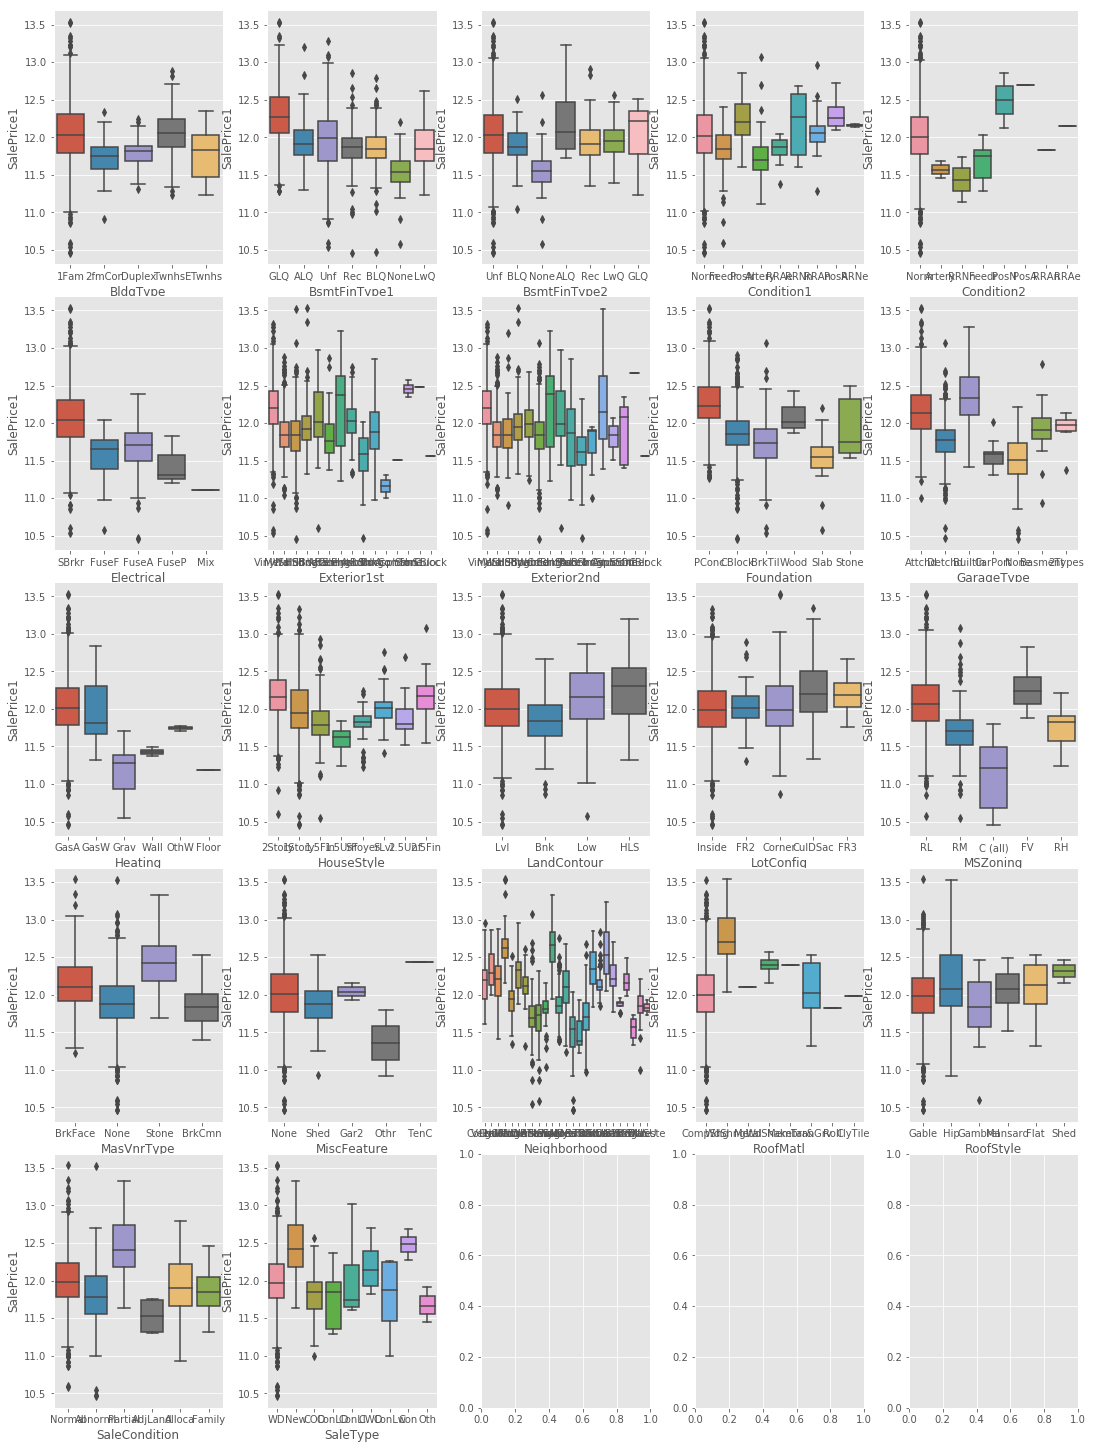

trainFinal (1460, 82)
testFinal (1459, 81)
yFinal (1460,)


In [13]:
# Prepare the data, pipeline for models evaluation

# PIPELINE
pipe = Pipeline([
    ('feat_eng', feat_eng()),
    ('add_feature', add_feature(additional=2)),
    ('lab_enc', labelenc()), 
    #('drop_cols', drop_cols()), 
    #('skew_dummies', skew_dummies(skew=1)), 
    ])
###                   ** skew_dummies is taking care of the labelencoder AND onehotencoder with get_dummies() !  **

train = pd.read_csv('./train.csv') 
test = pd.read_csv('./test.csv') 

trainWprice = pd.DataFrame(train)
#trainWprice = trainWprice.drop(trainWprice[(trainWprice['GrLivArea']>4000) & (trainWprice['SalePrice']<300000)].index)
trainNoPrice = trainWprice.drop("SalePrice", axis=1)

full=pd.concat([trainWprice,test], ignore_index=True)
full.drop(['Id'],axis=1, inplace=True)
print("full without Id and no price ", full.shape)


FullDataPipe = pipe.fit_transform(full)
print("FullDataPipe ", FullDataPipe.shape)

n_train=train.shape[0]
trainFinal = pd.DataFrame(FullDataPipe[:n_train])
testFinal = pd.DataFrame(FullDataPipe[n_train:])

y= train.SalePrice
yFinal = np.log(train.SalePrice)

boxplotall(trainFinal)

# Scaler should be run separately on train and test to prevent overfitting
scaler = RobustScaler()
#trainFinal = scaler.fit_transform(trainFinal)
#testFinal = scaler.fit_transform(testFinal)

# PCA should be run separately on train and test 
#pca = PCA(n_components = 0.999) 
# Check the number of feats that will keep 99.9% variance. Note the number may be different for train vs test
#pca = PCA(n_components = 200) 
#trainFinal = pca.fit_transform(trainFinal)
#testFinal = pca.fit_transform(testFinal)

print("trainFinal", trainFinal.shape)
print("testFinal", testFinal.shape)
print("yFinal", yFinal.shape)

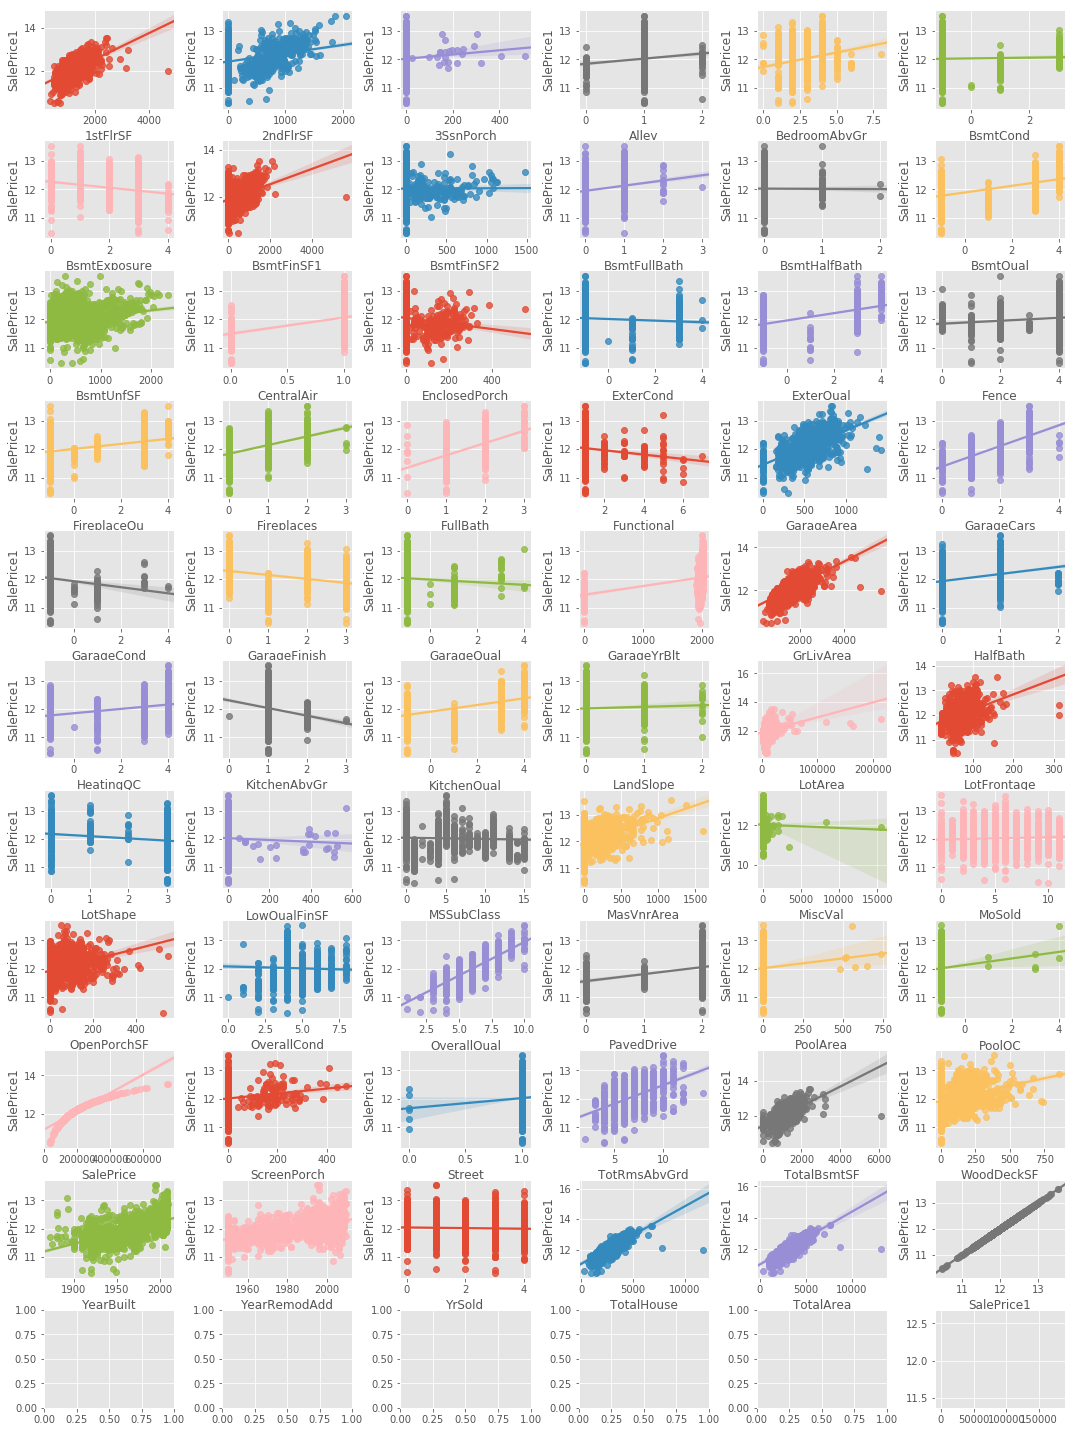

In [14]:
regplotall(trainFinal,order=1)

In [ ]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.graph_objs as go

fig = {
    'data': [
  		{
  			'x': df2007.gdpPercap, 
        	'y': df2007.lifeExp, 
        	'text': df2007.country, 
        	'mode': 'markers', 
        	'name': '2007'},
        {
        	'x': df1952.gdpPercap, 
        	'y': df1952.lifeExp, 
        	'text': df1952.country, 
        	'mode': 'markers', 
        	'name': '1952'}
    ],
    'layout': {
        'xaxis': {'title': 'GDP per Capita', 'type': 'log'},
        'yaxis': {'title': "Life Expectancy"}
    }
}

#fig = go.Figure(data=data, layout=layout)
plot([go.Scatter(x=[1, 2, 3], y=[3, 1, 6])])

In [15]:
# FEATURE IMPORTANCE - Needs its own SEPARATE pipeline without Scaler or PCA in order to see the features' NAMES and not their numbers
# Useful even AFTER PCA - check the relevance of features for prediction

trainFinalFI = pd.DataFrame(trainFinal)
yFinalFI = yFinal

lasso=Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
lasso.fit(trainFinalFI,yFinalFI)

FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=trainFinalFI.columns)

# Focus on those with 0 importance
#print(FI_lasso.sort_values("Feature Importance",ascending=False).to_string())
#print("_"*80)
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

ValueError: could not convert string to float: 'WD'

In [ ]:

# CHECK if any Missing Data
trainFinal = pd.DataFrame(trainFinal)

ColsMissingValues = trainFinal.isnull().sum()
print("There are ", len(ColsMissingValues[ColsMissingValues>0]), " features with missing values")
#print("_"*80)
all_data_na = (trainFinal.isnull().sum() / len(trainFinal)) * 100
all_data_na = all_data_na.sort_values(ascending=False)
#all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)
print(missing_data.head(len(ColsMissingValues[ColsMissingValues>0])))
print("_"*80)
print("trainFinal ", trainFinal.shape)
print("yFinal ", yFinal.shape)

In [ ]:
# define cross validation 
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

# Models

In [ ]:

# Lin reg ALL 14 models HYPERPARAMS NOT optimized
#models = [LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
#          ElasticNet(),SGDRegressor(),BayesianRidge(),KernelRidge(),ExtraTreesRegressor(),XGBRegressor(),lgb.LGBMRegressor()]
#names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb", "LightGBM"]

In [ ]:
# Some initial models with Hyper params optimized
models = [
    Lasso(alpha =0.0005, random_state=1),
    ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3),
    KernelRidge(alpha=2.2, coef0=2.5, degree=3, gamma=None, kernel='polynomial',kernel_params=None),
    SVR(C=2, cache_size=200, coef0=0.1, degree=3, epsilon=0.005, gamma=0.005,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.01, verbose=False),
    GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=5,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=2000,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False),
    #XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
    #                         learning_rate=0.05, max_depth=3, 
    #                         min_child_weight=1.7817, n_estimators=2200,
    #                         reg_alpha=0.4640, reg_lambda=0.8571,
    #                         subsample=0.5213, silent=1,
    #                         random_state =7, nthread = -1),
    #lgb.LGBMRegressor(objective='regression',num_leaves=5,
    #                          learning_rate=0.05, n_estimators=720,
    #                          max_bin = 55, bagging_fraction = 0.8,
    #                          bagging_freq = 5, feature_fraction = 0.2319,
    #                          feature_fraction_seed=9, bagging_seed=9,
    #                          min_data_in_leaf =6, min_sum_hessian_in_leaf = 11),
    
         ]

names = ["LASSO", "ELA","KER", "SVR ", "GBR" ]

In [ ]:
# Run the models and compare
ModScores = {}

for name, model in zip(names, models):
    score = rmse_cv(model, trainFinal, yFinal)
    ModScores[name] = score.mean()
    print("{}: {:.6f}".format(name,score.mean()))

print("trainFinal ", trainFinal.shape)
print("_"*80)
for key, value in sorted(ModScores.items(), key = itemgetter(1), reverse = False):
    print(key, value)

In [ ]:
# SEARCH GRID FOR HYPERPARAMS OPTIMIZATION

# SVR
param_grid = [{'kernel': ["rbf"], 'degree': [3]},
              {'gamma': [0.005],'coef0': [0.1,0.05],'tol': [0.01],
              'C': [2.5,2.2],'epsilon': [0.005],},]

In [ ]:
# Grid Search Optimization for models
model4cv = SVR()

grid_search = GridSearchCV(model4cv, param_grid)
grid_search.fit(trainFinal, yFinal)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print("_"*80)
print(grid(grid_search.best_estimator_).grid_get(trainFinal, yFinal,{}))

In [ ]:
# Optimized hyper params for models
lasso = Lasso(alpha =0.0005, random_state=1)

ker = KernelRidge(alpha=2.2, coef0=2.5, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None)

svr = SVR(C=2, cache_size=200, coef0=0.1, degree=3, epsilon=0.005, gamma=0.005,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.01, verbose=False)

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

ela = ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.05,
      max_iter=5000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

# Final Model fit, evaluation & predction

In [ ]:

# Final model fit, evaluation & prediction

model = SVR(C=2, cache_size=200, coef0=0.1, degree=3, epsilon=0.005, gamma=0.005,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.01, verbose=False)
#model = AveragingModels(models = (svr, ker))
#model = AveragingModels(models = (ela, svr, ker, gbr, lasso, xgb, lgb))

model.fit(trainFinal, yFinal)
score = rmse_cv(model, trainFinal, yFinal)
print(" model score: {:.5f} ({:.4f})\n".format(score.mean(), score.std()))

pred = np.exp(model.predict(testFinal))
pred = np.around(pred, decimals=4, out=None)
print(pred)

In [ ]:

# LEARNING CURVE
X, y = trainFinal, yFinal
estimator = model

title = "Learning Curves (SVR)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(estimator, title, X, y, ylim=(0.01, 0.17), cv=cv, n_jobs=4)

In [ ]:
# SUBMISSION
result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("submission.csv",index=False)
#print(result)